In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# block number 6 is good adaptation
# block number 7 is bad adaptation

In [3]:
def get_event_intervals(dfAdaptation) -> list:
    intervals = []
    workloads = []
    currentTime = 0
    currentDirection = 'less'
    currentWorkload = 'low'
    for idx, row in dfAdaptation.iterrows():
        if idx == 0:
            currentTime = row['Time']
            currentDirection = row['Direction']
            continue
        if currentDirection == row['Direction']:
            currentTime = row['Time']
            currentDirection = row['Direction']
        if currentDirection != row['Direction']:
            intervals.append((currentTime, row['Time']))
            currentTime = row['Time']
            oldDirection = currentDirection
            currentDirection = row['Direction']
            if oldDirection == 'less' and currentDirection == 'more':
                currentWorkload = 'low'
            elif oldDirection == 'more' and currentDirection == 'less':
                currentWorkload = 'high'
            workloads.append(currentWorkload)
    return intervals, workloads

def load_eda(pid):
    dfEDA = pd.read_csv(f"./data/ID{pid}-EDA.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")
    dfEDA.drop("TimeLsl", axis =1, inplace=True)

    intervals, workloads = get_event_intervals(dfAdaptation)
    for idx, interval in enumerate(intervals):
        dfEDA.loc[(dfEDA['Time'] >= interval[0]) & (dfEDA['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfEDA.loc[(dfEDA['Time'] >= interval[0]) & (dfEDA['Time'] <= interval[1]), 'interval_id'] = idx
    dfEDA = dfEDA[dfEDA['workload'].notna()]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][0]) & (dfEDA.Time < dfState['Time'][0+1])].index, 'BlockNumber']   = dfState['BlockNumber'][0]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][2]) & (dfEDA.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][4]) & (dfEDA.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][6]) & (dfEDA.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][8]) & (dfEDA.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][10]) & (dfEDA.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][12]) & (dfEDA.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]
    dfEDA = dfEDA.dropna()
    dfEDA = dfEDA.sort_values(by="Time")
    return dfEDA

def extract_eda_features(pid, df):
    df_features = pd.DataFrame()
    intervals = df.interval_id.unique()
    for interval_id in intervals:
        df_current = df[df.interval_id == interval_id]
        if len(df_current['Value']) < 50:
            df_features = df_features.append(pd.DataFrame.from_dict([{
                'pid': pid,
                'workload': df_current['workload'].iloc[0],
                'interval': interval_id,
            }]))
            continue
        eda_clean, _ = nk.eda_process(df_current['Value'], sampling_rate=250)
        df_features = df_features.append(pd.DataFrame.from_dict([{
            'pid': pid,
            'workload': df_current['workload'].iloc[0],
            'block_number': df_current['BlockNumber'].iloc[0],
            'interval': interval_id,
            'tonic_avg': np.mean(eda_clean['EDA_Tonic']),
            'amplitude_avg': np.mean(eda_clean["SCR_Amplitude"]),
            'peaks_num': np.sum(eda_clean['SCR_Peaks']),

        }]))
    return df_features

In [4]:
pid_valid = list(range(1, 24))
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df = load_eda(pid)
    df_all[pid] = df

100%|██████████| 23/23 [00:07<00:00,  3.23it/s]


In [5]:
df = pd.DataFrame()
for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df_features = extract_eda_features(pid, df_all[pid])
    df = df.append(df_features)
df

100%|██████████| 23/23 [00:03<00:00,  7.47it/s]


,pid,workload,block_number,interval,tonic_avg,amplitude_avg,peaks_num
0,1,low,6.0,0.0,202612.311423,4.423710,3
0,1,high,6.0,1.0,199846.766056,5.069771,2
0,1,low,6.0,2.0,197382.276587,0.961326,7
0,1,high,6.0,3.0,193358.656033,3.505737,4
0,1,low,7.0,4.0,253405.759206,12.024656,4
...,...,...,...,...,...,...,...
0,23,low,7.0,10.0,402966.221102,0.548252,6
0,23,high,7.0,11.0,405739.887013,1.786874,5
0,23,low,7.0,12.0,406395.012070,2.438641,4
0,23,high,7.0,13.0,405812.077719,0.762708,4


In [6]:
df['tonic_avg_norm'] = (df['tonic_avg'] - df['tonic_avg'].min()) / (df['tonic_avg'].max() - df['tonic_avg'].min())
df['amplitude_avg_norm'] = (df['amplitude_avg'] - df['amplitude_avg'].min()) / (df['amplitude_avg'].max() - df['amplitude_avg'].min())

In [7]:
df.reset_index(inplace=False, drop=True)

,pid,workload,block_number,interval,tonic_avg,amplitude_avg,peaks_num,tonic_avg_norm,amplitude_avg_norm
0,1,low,6.0,0.0,202612.311423,4.423710,3,0.463298,0.337656
1,1,high,6.0,1.0,199846.766056,5.069771,2,0.456014,0.386969
2,1,low,6.0,2.0,197382.276587,0.961326,7,0.449524,0.073377
3,1,high,6.0,3.0,193358.656033,3.505737,4,0.438927,0.267588
4,1,low,7.0,4.0,253405.759206,12.024656,4,0.597073,0.917825
...,...,...,...,...,...,...,...,...,...
192,23,low,7.0,10.0,402966.221102,0.548252,6,0.990970,0.041847
193,23,high,7.0,11.0,405739.887013,1.786874,5,0.998275,0.136390
194,23,low,7.0,12.0,406395.012070,2.438641,4,1.000000,0.186138
195,23,high,7.0,13.0,405812.077719,0.762708,4,0.998465,0.058216


In [8]:
df = df[(df.block_number == 6) | (df.block_number == 7)]
df.to_csv("./processed/eda.csv", index=False)

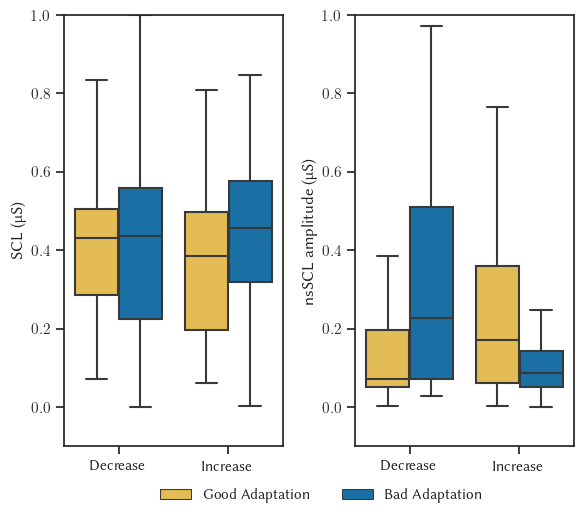

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='tonic_avg_norm', data=df, ax=axes[0], hue='block_number', palette=colors, showfliers=False)
sns.boxplot(x='workload', y='amplitude_avg_norm', data=df, ax=axes[1], hue='block_number', palette=colors, showfliers=False)

axes[0].set_ylabel('SCL (µS)')
axes[1].set_ylabel('nsSCL amplitude (µS)')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.1, 1)

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, ['Good Adaptation', 'Bad Adaptation'], loc='lower center', ncol=2, bbox_to_anchor=(0.55, -.05), frameon=False)

plt.tight_layout()
plt.savefig('figures/fig1eda.pdf')

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk
import mne
from mne_icalabel import label_components
mne.set_log_level('WARNING')
from scipy.integrate import simpson # composite Simpson's rule

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('processed/eda.csv')

[(0.46988778, 0.58774195, 0.75682037), (0.77636283, 0.46912235, 0.45984473)]


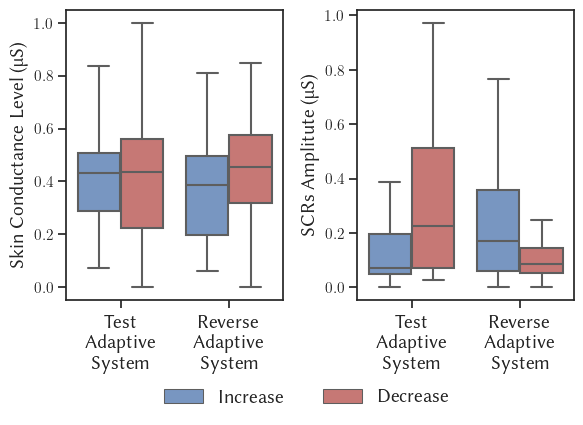

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
colors = sns.color_palette('vlag', n_colors=5)
# colors = sns.color_palette('coolwarm', n_colors=10)
colors = [colors[0], colors[-1]]
print(colors)
# colors = sns.diverging_palette(220, 20, as_cmap=False, n=2)
saturation = 1
# colors = list({'yellow' : '#458a57', 'blue': '#ab334d'}.values())
sns.boxplot(x='workload', y='tonic_avg_norm', data=df, ax=axes[0], hue='block_number', palette=colors, showfliers=False, saturation=saturation)
sns.boxplot(x='workload', y='amplitude_avg_norm', data=df, ax=axes[1], hue='block_number', palette=colors, showfliers=False, saturation=saturation)


axes[0].set_ylabel('Skin Conductance Level (µS)', fontsize=14)
axes[1].set_ylabel('SCRs Amplitute (µS)', fontsize=14)

axes[0].set_xticklabels(['Test \nAdaptive\nSystem', 'Reverse \nAdaptive\nSystem'], fontsize=14)
axes[1].set_xticklabels(['Test \nAdaptive\nSystem', 'Reverse \nAdaptive\nSystem'], fontsize=14)

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].legend().remove()
axes[1].legend().remove()

# fig.suptitle('Adaptation Visual Complexity (EDA)')

# create legend
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Increase', 'Decrease'], loc='upper center', ncol=2, bbox_to_anchor=(0.525, 0.05), frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig('figures/fig4a.pdf', bbox_inches='tight')